## Linear regression

This assignment is dedicated to Linear regression. 12 task, 30 points max.

By focusing on predicting different features of football players,
you will:
* gain understanding of mathematics behind Linear Regression model
* and become familiar with using `sklearn` library for solving this kind of tasks

In the assignment we will:
* build Linear regression models with 1 and many variables
* use both library methods and manual calculations using mathematical formulas
* implement main regression metrics to evaluate performance of our models
* explore limitations of classical linear regression

### Notes:
* do not modify `assert` blocks in code. They are used to check your results
    

### Data
- In this notebook we will work with Football Player attributes per each match played.
  
  Data is taken from [European Soccer Database](https://www.kaggle.com/hugomathien/soccer) dataset. 
  
  The table used is `Player_Attributes`.


### Materias

Start with the assignment first. Use materials below as references when needed.

* NumPy:
    - [quickstart](https://numpy.org/doc/stable/user/quickstart.html)
    - [api reference](https://numpy.org/doc/stable/reference/index.html)
    

* Pandas:
    - [10 minutes to pandas](https://pandas.pydata.org/docs/user_guide/10min.html)
    - guide on [groupby.transform](https://pandas.pydata.org/docs/user_guide/groupby.html#transformation). 
      used in one of tasks on data preprocessing
    - [cheat sheet](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)
    

* sklearn:
    - [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) class documentation
    - guide on [Linear models](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares)


* Matplotlib:
    - [cheatsheet](https://matplotlib.org/cheatsheets/)
    - examples of [main plot types](https://matplotlib.org/stable/plot_types/index.html)
    - [scatter plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) documentation

In [2235]:
import os

import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 100
pd.options.mode.chained_assignment = 'raise'  # forbid chained assignment to prevent implicit errors

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7, 6)  # set default figure size

import seaborn as sns
sns.set(font_scale=1.1)  # increase default font scale and set seaborn's plot style

from typing import List, Iterable

## Data Processing

In [2236]:
data_root_dp = os.path.join('c:', 'data', 'tmp')  # change to yours path
print(f'data_root_dp: "{data_root_dp}"')

data_root_dp: "c:data\tmp"


### read the raw SQL data
* you can run this code only once.<br>
  it will read `.sqlite` file and save extracted data to a more handy `.csv` format

In [2237]:
 #import sqlite3

 # # open connection to .sqlite file
 # data_sql_fp = os.path.join(data_root_dp, 'database.sqlite')
 # print(f'will read from: "{data_sql_fp}"')
 # con = sqlite3.connect(data_sql_fp)

 # df = pd.read_sql('select * from Player_Attributes', con)  # run SQL-query
 # print(f'shape: {df.shape}')
 # con.close()  # close connection to .sqlite file

# # save to .csv
# out_fp = os.path.join(data_root_dp, 'tmp', 'player_attributes.csv')
# os.makedirs(os.path.dirname(out_fp), exist_ok=True)  # create directories if needed
# print(f'will save to: "{out_fp}"')
# df.to_csv(out_fp, index=False)

### read the  data

In [2238]:
data_player_attributes_fp = os.path.join(data_root_dp, 'player_attributes.csv')
print(f'reading from: "{data_player_attributes_fp}"')
df = pd.read_csv(data_player_attributes_fp)
print(df.shape)

reading from: "c:data\tmp\player_attributes.csv"
(183978, 42)


In [2239]:
df.dtypes

id                       int64
player_fifa_api_id       int64
player_api_id            int64
date                    object
overall_rating         float64
potential              float64
preferred_foot          object
attacking_work_rate     object
defensive_work_rate     object
crossing               float64
finishing              float64
heading_accuracy       float64
short_passing          float64
volleys                float64
dribbling              float64
curve                  float64
free_kick_accuracy     float64
long_passing           float64
ball_control           float64
acceleration           float64
sprint_speed           float64
agility                float64
reactions              float64
balance                float64
shot_power             float64
jumping                float64
stamina                float64
strength               float64
long_shots             float64
aggression             float64
interceptions          float64
positioning            float64
vision  

### basic data processing

In [2240]:
# there are 3 'id' columns in data. 
# we will use 'player_api_id' only
# and drop other 'id' columns.
redundant_key_columns = ['id', 'player_fifa_api_id']

# also we will drop categorical columns for this task.
categorical_columns = ['preferred_foot', 'attacking_work_rate', 'defensive_work_rate']

cols_to_drop = redundant_key_columns + categorical_columns
print(f'will drop following columns: {cols_to_drop}')
df.drop(columns=cols_to_drop, inplace=True)

# rename 'player_api_id' column to shorter one: 'id'.
df.rename(columns={'player_api_id': 'id'}, inplace=True)

# cast string values to datetime
df['date'] = pd.to_datetime(df['date'])

# drop records that contain only NaNs in features
all_features = set(df.columns).difference(['id', 'date'])  # all columns without key columns
df.dropna(subset=all_features, how='all', inplace=True)

print(f'df.shape: {df.shape}')

will drop following columns: ['id', 'player_fifa_api_id', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate']
df.shape: (183142, 37)


In [2241]:
# the dataset we're working with migh get updated in future (new records might be added).
# thus we remove any records with date larger than the current max date in data (2016-07-07)
# for compatibility with current version of notebook.
df.drop(index=df[df['date'] > '2016-07-07'].index, inplace=True)
print(df.shape)

(183142, 37)


### drop duplicates

* we should **ALWAYS** understand what our data represents


* here we are dealing with Football Player attributes per each match played.

  so we expect the data to have `(id, date)` as a key
  
  
* let's check whether our assumption holds

In [2242]:
df.duplicated(['id', 'date']).value_counts()

False    183142
dtype: int64

* there are no duplicates if considering `(id, date)` pair as a key

In [2243]:
df.duplicated('id').value_counts()

True     172082
False     11060
dtype: int64

* and there are duplicates if considering only `id` column as a key

* so our assumption holds. but let's work only with latest stats for each player

#### Task 1. Keep only latest data for each player (1 point)

* HINT: you can use 

  `df[<new_column>] = df.groupby(<key_to_aggregate>)[<column>].transform('max')` 
  
  to get the `max` value of `<column>` for each group specified by `<key_to_aggregate>` columns.
  
  then you'll have to filter rows using `<column>` and `<new_column>` values
  

* don't forget to remove any additional columns you introduce here

In [2244]:
# your code here

df['last_date'] = df.groupby('id')['date'].transform('max')
df = df[df.date == df.last_date].copy()
df.drop(columns = ['last_date'], axis = 1, inplace=True)

print(df.shape)

(11060, 37)


In [2245]:
assert df.duplicated(['id']).sum() == 0
assert df.shape == (11060, 37)

In [2246]:
# no longer need 'id' and 'date' columns
df.drop(columns=['id', 'date'], inplace=True)

### NaNs

In [2247]:
df.isna().sum()

overall_rating          0
potential               0
crossing                0
finishing               0
heading_accuracy        0
short_passing           0
volleys               478
dribbling               0
curve                 478
free_kick_accuracy      0
long_passing            0
ball_control            0
acceleration            0
sprint_speed            0
agility               478
reactions               0
balance               478
shot_power              0
jumping               478
stamina                 0
strength                0
long_shots              0
aggression              0
interceptions           0
positioning             0
vision                478
penalties               0
marking                 0
standing_tackle         0
sliding_tackle        478
gk_diving               0
gk_handling             0
gk_kicking              0
gk_positioning          0
gk_reflexes             0
dtype: int64

* do you see any pattern in how NaNs are distributed?

In [2248]:
df.isna().sum(axis=1).value_counts()

0    10582
7      478
dtype: int64

#### Task 2. Drop rows that contain NaNs (1 point)

In [2249]:
# your code here

df = df.dropna()

In [2250]:
assert df.isna().sum().sum() == 0

## Task 3. Implement main regression metrics yourself (up to 4 points):
* Mean Squared Error (mse) - **(1 point)**
* Mean Absolute Error (mae) - **(1 point)**
* Mean Absolute Percentage Error (mape) - **(1 point)**
* R-squared (r2) - **(1 point)**


#### bonus point: MAPE is implemented in such way to take possible 0 in `y_true` into account
Hints:

* you should divide on 
  $ \hat{y}_{true} = (\hat{y}_{true}^{(0)}, \hat{y}_{true}^{(1)}, ..., \hat{y}_{true}^{(n)}) $,
  
  where $ \ \ \hat{y}_{true}^{(i)} = max(\ \ | y_{true}^{(i)} |, \ \ \epsilon), \ \ \epsilon > 0, \ \ y_{true}^{(i)} \in \mathbb R $
  

* for compatibility with `sklearn` take 

  `eps = np.finfo(np.float64).eps`
  
  
#### bonus point: $R^2$ is implemented in such way to take possible 0 in numerator and denominator into account
Hints:

* recall the formula: $ R^2 = 1 - \dfrac{SS_{residuals}}{SS_{total}} $


* you should return:

    $
    \begin{cases}
     R^2 & \text{ if } SS_{residuals} \ne 0 \text{ and  } SS_{total} \ne 0 
     \\
     0 & \text{ if } SS_{residuals} \ne 0 \text{ and  } SS_{total} = 0 
     \\
     1 & \text { otherwise }
    \end{cases}
    $
    

* for a better understanding of $R^2$ coefficient 
  try to explain to yourself why we return those values in each of edge cases

In [2251]:
# we use '*' in the beggining of each function signature
# to forbid positional arguments and enforce the use of kwargs.
# this helps to avoid mistake when arguments are passed in wrong order.

# write down code instead of raising NotImplementedError in each of functions below.

def mse(*, y_true, y_pred):
    if not all([isinstance(y_true, np.ndarray),
                isinstance(y_pred, np.ndarray)]):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.square(np.subtract(y_true, y_pred)).mean()
    
def mae(*, y_true, y_pred):
    if not all([isinstance(y_true, np.ndarray),
                isinstance(y_pred, np.ndarray)]):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))
    
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    eps = np.finfo(np.float64).eps
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / eps
    return res

def mape(*, y_true, y_pred):
    if not all([isinstance(y_true, np.ndarray),
                isinstance(y_pred, np.ndarray)]):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(percentage_error(y_true, y_pred)))
    
    
def r2(*, y_true, y_pred):
    if not all([isinstance(y_true, np.ndarray),
                isinstance(y_pred, np.ndarray)]):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
    ssr  = np.square( y_pred - y_true ).sum()
    sst  = np.square( y_true - y_true.mean() ).sum()
    if (ssr != 0) & (sst != 0): 
        return 1 - ssr/sst
    if (ssr != 0) & (sst == 0): 
        return 0
    return 1
    

### Validate your implementations are correct

* we'll use synthetic data for this task


In [2252]:
from sklearn.metrics import (
    mean_squared_error as mse_lib, 
    mean_absolute_error as mae_lib,
    mean_absolute_percentage_error as mape_lib,
    r2_score as r2_lib
)

In [2253]:
def compare_metrics(fn, fn_lib, y_true, y_pred, n_digits=9):
    """ Print and compare values of custom and library functions using given precision. """
    m_fn = fn(y_true=y_true, y_pred=y_pred)
    m_fn_lib = fn_lib(y_true=y_true, y_pred=y_pred)
    print(f'{fn.__name__} custom : {m_fn}')
    print(f'{fn.__name__} library: {m_fn_lib}')
    print()
    assert round(m_fn, n_digits) == round(m_fn_lib, n_digits)

#### a case with a good fit

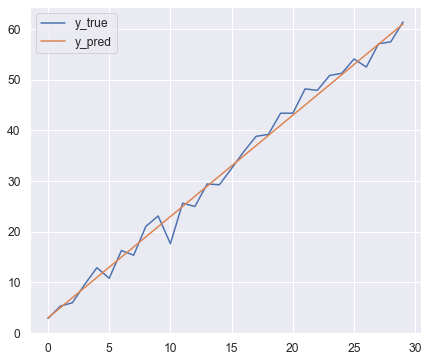

In [2254]:
n = 30
x = np.arange(n)
y_true = 2 * x + 3 + np.random.normal(loc=0, scale=2, size=n)
y_pred = 2 * x + 3

plt.plot(x, y_true, label='y_true')
plt.plot(x, y_pred, label='y_pred')
plt.legend();

In [2255]:
compare_metrics(mse, mse_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mae, mae_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mape, mape_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('all tests passed')

mse custom : 3.119193010376424
mse library: 3.119193010376424

mae custom : 1.3749463351155726
mae library: 1.3749463351155726

mape custom : 0.06379357387759707
mape library: 0.06379357387759707

r2 custom : 0.9898754171378462
r2 library: 0.9898754171378462

all tests passed


#### 0s in target. MAPE should explode

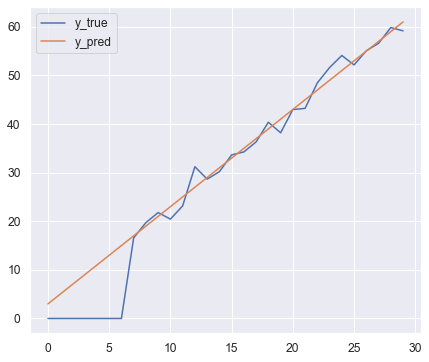

In [2256]:
n = 30
x = np.arange(n)
y_true = 2 * x + 3 + np.random.normal(loc=0, scale=2, size=n)
y_true[:7] = 0
y_pred = 2 * x + 3

plt.plot(x, y_true, label='y_true')
plt.plot(x, y_pred, label='y_pred')
plt.legend();

In [2257]:
compare_metrics(mse, mse_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mae, mae_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mape, mape_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('all tests passed')

mse custom : 24.892922386582498
mse library: 24.892922386582498

mae custom : 3.129954424809256
mae library: 3.129954424809256

mape custom : 9457559217478042.0
mape library: 9457559217478042.0

r2 custom : 0.939500111894431
r2 library: 0.939500111894431

all tests passed


#### edge cases for R2

In [2258]:
# constant target value

n = 30
x = np.arange(n)
y_true = np.repeat(15, n)
y_pred = 2 * x + 3

compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('success')

r2 custom : 0
r2 library: 0.0

success


In [2259]:
# perfect fit

n = 30
x = np.arange(n)
y_true = 2 * x + 3 + np.random.normal(loc=0, scale=2, size=n)
y_pred = y_true

compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('success')

r2 custom : 1
r2 library: 1.0

success


### Define helper functions

In [2260]:
def get_metrics(*, y_true, y_pred) -> pd.Series:
    """ A helper function to return all metrics for given labels and predictions. """
    
    # if you didn't implement some metrics, comment them out for this function to work.
    return pd.Series({
        'mse': mse(y_true=y_true, y_pred=y_pred),
        'mae': mae(y_true=y_true, y_pred=y_pred),
        'mape': mape(y_true=y_true, y_pred=y_pred),
        'r2': r2(y_true=y_true, y_pred=y_pred),
    })

In [2261]:
def fit_and_evaluate(model, x_train, y_train, x_test, y_test) -> pd.DataFrame:
    """ 
    A helper function to: 
    * fit a passed model
    * and return metrics on train and test sets.
    """
    # fit the model
    model.fit(x_train, y_train)
    
    # return metrics as pd.DataFrame
    m = pd.DataFrame([
        get_metrics(y_true=y_train, y_pred=model.predict(x_train)),  # metrics for train set
        get_metrics(y_true=y_test, y_pred=model.predict(x_test))     # metrics for test set
    ], index=['train', 'test']
    )
    
    return m

## train/test split

* Split the data we have into Train and Test splits with 80%/20% proportion

In [2262]:
print(df.shape)
ix_split = int(0.8 * df.shape[0])
DF_TRAIN = df.iloc[:ix_split].copy()
DF_TEST = df.iloc[ix_split:].copy()
print(DF_TRAIN.shape, DF_TEST.shape)

(10582, 35)
(8465, 35) (2117, 35)


In [2263]:
def get_train_test_data(features: List[str], target: str) -> tuple:
    """
    Return x_train, y_train, x_test, y_test using 
    * global train/test split 
    * features and target provided.
    """
    # in general, it's a bad practice to use global variables. 
    # however, we use it here with caution for simplicity.
    return (
        DF_TRAIN[features].copy(), DF_TRAIN[target].copy(), 
        DF_TEST[features].copy(), DF_TEST[target].copy()
    )

## Linear regression with 1 variable

* Let's start with Linear Regression that predicts target variable 
  using only 1 predictor (independent variable)  

* We will try to predict `dribbling` variable using `short_passing` as a predictor

In [2264]:
target = 'dribbling'
features = ['short_passing']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)
type(x_train)

pandas.core.frame.DataFrame

### Let's visualize our data first

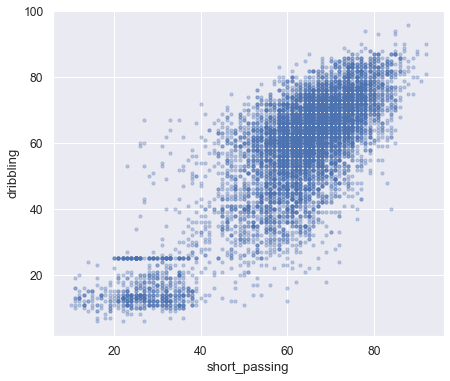

In [2265]:
plt.scatter(x=x_train, y=y_train, alpha=0.3, s=10);
plt.xlabel('short_passing');
plt.ylabel('dribbling');

* do you notice anything interesting on this plot?
* if so, how can we use it later to generate more accurate predictions?

> It looks like more 'short_passing' a player perfoms, the better he is in 'dribbling'. However, "dribbling" 
> does not really depend on 'short_passing'.

### Task 4. Compute Pearson correlation coefficient between feature and target (1 pont)
Hint: you can use either `pd.Series.corr` method or `np.corrcoef` function

In [2266]:
# your code here

corrcoef = x_train.squeeze().corr(y_train)
corrcoef

0.8094048458494031

### Solve using `sklearn`

* we will use `LinearRegression` class from `sklearn` library 
  to fit a linear regression model and use it to generate prediction

In [2267]:
from sklearn.linear_model import LinearRegression

In [2268]:
model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train);

* explore fitted model parameters

In [2269]:
model_intercept = model.intercept_
model_slope = model.coef_[0]

print(f'model_intercept: {model_intercept}')
print(f'model_slope: {model_slope}')

model_intercept: -6.211029905026031
model_slope: 1.0366141627766248


* use fitted model to get predictions for test set

In [2270]:
model_preds = model.predict(x_test)
model_preds

array([55.98581986, 65.31534733, 44.58306407, ..., 62.20550484,
       54.9492057 , 76.71810312])

* explore model quality on test set.

In [2271]:
print('model metrics on test set')
metrics_test_1 = get_metrics(y_true=y_test, y_pred=model_preds)
metrics_test_1

model metrics on test set


mse     108.345801
mae       8.173553
mape      0.205500
r2        0.681477
dtype: float64

* can you explain what those metic values mean?

> *mse* is suitable for comparing two models or for quality control in training,  but does not allow one to 
> draw conclusions about how well a given model solves a problem. Since the target variable lies in the interval (6, 96), 
> the result indicates that there are many errors.
>
> *mape* here is around 20%, it means acceptable prediction accuracy; 
>
> *r2* is the normalized root mean square error. If it is close to one, then the model explains the data well; if it 
> is close to zero, then the quality forecasts are comparable to a constant forecast. In our case, 68.14%, this 
> means that data here do not perfectly fit to the linear model, and some variability is present


#### Task 5. Calculate predictions for test set manually (1 point)

Above we used `LinearRegression.predict()` method to obtain predictions. 
Now let's do it manually!

Recall Linear Regression formula:

* $ \hat{y} = w_0 + w_1 \cdot x, $ 

    where:
    * $w_0$ is an intercept
    * $w_1$ is a slope
    * $x$ is a predictor
    * $\hat{y}$ is a predicted variable
  

* use intercept and slope values from fitted LinearRegression model

In [2272]:
# use `x_test` for calculations as is (it's a DataFrame with 1 column).
# do not convert it to Series or numpy array.

# your code here:
model_manual_preds = model_intercept + model_slope * x_test
# model_manual_preds

In [2273]:
assert isinstance(model_manual_preds, pd.DataFrame)

In [2274]:
# ensure our manual predictions are the same as model generated
assert np.allclose(model_preds, model_manual_preds.iloc[:, 0].to_numpy())
print('success')

success


#### Task 6. Plot test data and predicted values (1 point)

* use `plt.scatter` function as in example above.
* first build scatter plot for test data
* then build scatter plot with model predictions
* add plot title, axis names and legend

Hints:
* use `alpha` parameter to control opacity and `s` parameter to control size of points.
  this will make plot more readable
* use `label` parameter to add label to each set of points added to scatter plot
* use different color for model predictions. control with parameter `color`

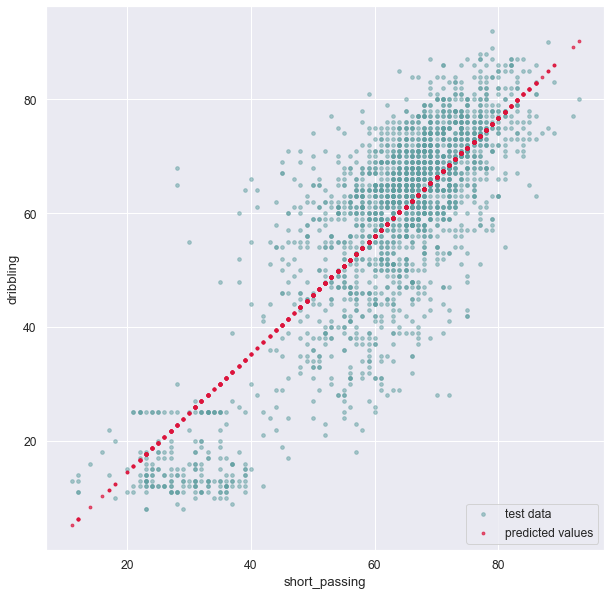

In [2275]:
# your code here

plt.figure(figsize=(10, 10))
plt.scatter(x=x_test, y=y_test, alpha=0.5, s=13, c='#5F9EA0');
plt.xlabel('short_passing');
plt.ylabel('dribbling');

plt.scatter(x=x_test, y=model_preds, alpha=0.7, s=8, c='#DC143C')
plt.legend(['test data', 'predicted values'], ncol = 1 , loc = 'lower right');  # adds legend to a plot

### Task 7.  Fit regression model manually (3 points)

So far we have used `sklearn` library to fit linear regression model and obtain predictions. Good job!

Recall the formula of Linear regression for 1 variable:

* $ \hat{y} = w_0 + w_1 \cdot x $

Now let's try to fit the model **ourselves**.

### Theory

Assume our dataset consists of _n_ samples.

To fit a Linear regression model means to find the best set of parameters - 
$(w_0, w_1)$ that minimizes a **Loss function**.<br>
In case of Linear regression we choose **Residual sum of squares (RSS)** as a Loss function:

* $ L(w, x, y) = RSS(w, x, y) = \sum_{i=0}^{n-1} (y_i - \hat{y}_i ) ^ 2 \rightarrow min $

That is conceptually the same as minimizing Mean squared error (MSE):

* $ MSE(w, x, y) = \dfrac{1}{n} \sum_{i=0}^{n-1} (y_i - \hat{y}_i ) ^ 2 \rightarrow min $

Here:
* $y = (y_0, y_2, ..., y_{n-1}) $ - is a vector of target values we want to predict.
  1 value per each sample in our dataset that consists of _n_ samples
* $\hat{y} = (\hat{y}_0, \hat{y}_2, ..., \hat{y}_{n-1}) $ - is a vector of predictions 
* $\hat{y}_i = w_0 + w_1 \cdot x_i$ - is an individual prediction for _i_-th sample in a dataset

---

Best parameters $w_0$ and $w_1$ can be found using **following formulas**:

* $w_0 = \bar{y} - w_1 \cdot \bar{x}$


* $w_1 = \dfrac{\sum_{i=0}^{n-1}(x_i - \bar{x}) y_i}{\sum_{i=0}^{n-1}(x_i - \bar{x})^2}$


* where:
 * $\bar{x} = \dfrac{1}{n} \sum_{i=0}^{n-1}x_i$ - is the mean of vector $x$
 
 * $\bar{y} = \dfrac{1}{n} \sum_{i=0}^{n-1}y_i$ - is the mean of vector $y$
 
You should use these formulas to find the best model parameters in this task.
 
---

If you want to learn more you can refer to 
[Simple linear regression](https://en.wikipedia.org/wiki/Simple_linear_regression) wiki-page.

It contains analagous formula for $w_1$ coefficient that is conceptually the same 
(so it's not a bug in our formula provided above).

### Implementation

* convert pd.DataFrame and pd.Series (`x_train` and `y_train` respecitvely) to numpy-arrays

In [2276]:
x = x_train.iloc[:, 0].to_numpy()
y = y_train.to_numpy()

* calculate model parameters ($w_1$ - slope and $w_0$ - intercept) using formulas given above

In [2277]:
# your code here:

n = np.size(x)
 
m_x = np.mean(x)
m_y = np.mean(y)
 
SS_xy = np.sum(y*x) - n*m_y*m_x
SS_xx = np.sum(x*x) - n*m_x*m_x

manual_slope = SS_xy / SS_xx
manual_intercept = m_y - manual_slope*m_x

In [2278]:
print(f'manual_intercept: {manual_intercept}')
print(f'manual_slope: {manual_slope}')

manual_intercept: -6.211029905025917
manual_slope: 1.036614162776623


In [2279]:
assert round(model_intercept, 9) == round(manual_intercept, 9)
assert round(model_slope, 9) == round(manual_slope, 9)
print('success')

success


## Linear regression with multiple variables

* Now let's use Linear Regression model that uses multiple variables

* We will try to predict `dribbling` variable using 
  `['ball_control', 'short_passing', 'strength', 'sprint_speed']` features

In [2280]:
target = 'dribbling'
features = ['ball_control', 'short_passing', 'strength', 'sprint_speed']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

### Let's explore the data first

In [2281]:
cols = features + [target]
print(cols)

['ball_control', 'short_passing', 'strength', 'sprint_speed', 'dribbling']


#### Task 8 (1 point)

Build pairwise correlation matrix for selected features and target. Visualize it with heatmap.

Hints:
* use `DF_TRAIN` to build statistics (`x_train` contains only features. target is in `y_train`)
* use `pd.DataFrame.corr()` to build correlation matrix
* use `sns.heatmap` to build heatmap from correlation matrix. 
  * use `center` parameter to center your heatmap's colormap at 0
  * use diverging colormap (`cmap` parameter)<br>
    you can find the list of diverging colormaps
    [here](https://matplotlib.org/stable/tutorials/colors/colormaps.html#diverging)<br>
    the reason is that we need to easily find both negative and positive correlations.
  * use `annot` parameters to add numbers to the plot.
* you can print `pd.DataFrame` and build plot in the same cell.<br> 
  use `display(...)` function that accets `pd.DataFrame` before building the plot
  
You can refer to [seaborn.heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) documentation

,ball_control,short_passing,strength,sprint_speed,dribbling
ball_control,1.000000,0.904857,-0.024422,0.572677,0.919271
short_passing,0.904857,1.000000,0.039196,0.450801,0.809405
strength,-0.024422,0.039196,1.000000,-0.203386,-0.150197
sprint_speed,0.572677,0.450801,-0.203386,1.000000,0.656453
dribbling,0.919271,0.809405,-0.150197,0.656453,1.000000


ball_control     0.919271
short_passing    0.809405
strength         0.150197
sprint_speed     0.656453
dribbling        1.000000
Name: dribbling, dtype: float64

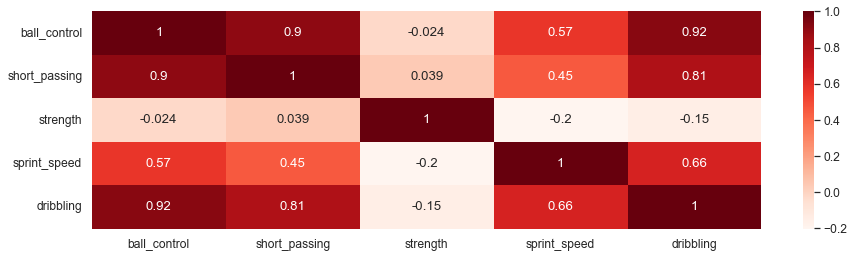

In [2282]:
# your code here
correlation_matrix = DF_TRAIN[cols].corr()
display(correlation_matrix)

plt.figure(figsize=(15, 4))
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.Reds)

cor_target = abs(correlation_matrix[target])
cor_target

* what can you say about selected feature set using this correlation matrix?

> _The features 'ball_control', 'short_passing' and 'sprint_speed' are highly correlated with the output variable 'dribbing'. But the independent 
> variables need to be uncorrelated with each other._

#### Let's build pairplots for features and target

* `plot_kws` parameter accepts dictionary of keyword arguments 
  that are passed to bivariate plotting function (`sns.scatterplot` in this case)


* we set size to 7 (using `s` parameter) to make points smaller and see patterns clearly.<br>
  you can compare this to running with not `plot_kws` passed.
  

* `alpha` parameter also helps to see data distribution clearly


* you can also experiment with `kind` parameter - refer to
  [seaborn.pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html)
  documentation for possible values.

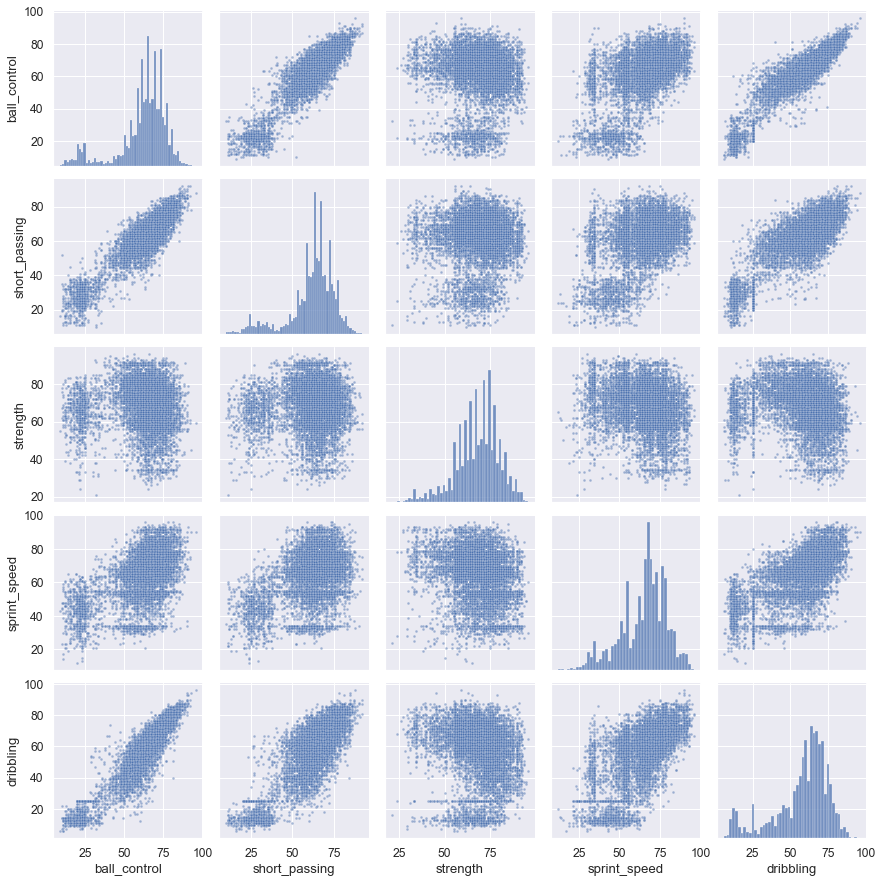

In [2283]:
sns.pairplot(DF_TRAIN[cols], plot_kws={'s': 7, 'alpha': 0.5});

* what can you say about these scatterplots? is there anything we can use later?

> Probably, they provide a more detailed visualized confirmation of a heatmap from above.

 ### Solve using `sklearn`

In [2284]:
model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train);

* explore fitted model parameters

In [2285]:
model_intercept = model.intercept_
model_coef = model.coef_
print(f'model_intercept: {model_intercept}')
print(f'model_coef: {model_coef}')

model_intercept: -4.410760994496663
model_coef: [ 0.98220522 -0.03927767 -0.14440889  0.20772844]


* how to interpret these model parameters?

> *model_intercept:* The intercept represents the mean value of the response variable when all of the predictor variables 
> in the model are equal to zero. I think, the negative y-intercept for this regression model has no real meaning.
>
>
> *model_coef:* The coefficients for each predictor variable tell us the average expected change in the response variable, assuming the 
> other predictor variable remains constant.
>

* use fitted model to get predictions for test set

In [2286]:
model_preds = model.predict(x_test)
model_preds

array([44.30711902, 61.5246943 , 56.23794497, ..., 64.14903371,
       57.22105591, 75.15698321])

* explore model quality on test set.

In [2287]:
print('model metrics on test set')
metrics_test_2 = get_metrics(y_true=y_test, y_pred=model_preds)
metrics_test_2

model metrics on test set


mse     38.192447
mae      4.459334
mape     0.112574
r2       0.887719
dtype: float64

* Let's compare `metrics_test_2` against `metrics_test_1`

In [2288]:
# combine 2 series in 1 dataframe
metrics_comparison = metrics_test_1.to_frame('LR_1v').join(metrics_test_2.rename('LR_mv')).T
metrics_comparison

,mse,mae,mape,r2
LR_1v,108.345801,8.173553,0.205500,0.681477
LR_mv,38.192447,4.459334,0.112574,0.887719


C:\Users\TamiKo\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


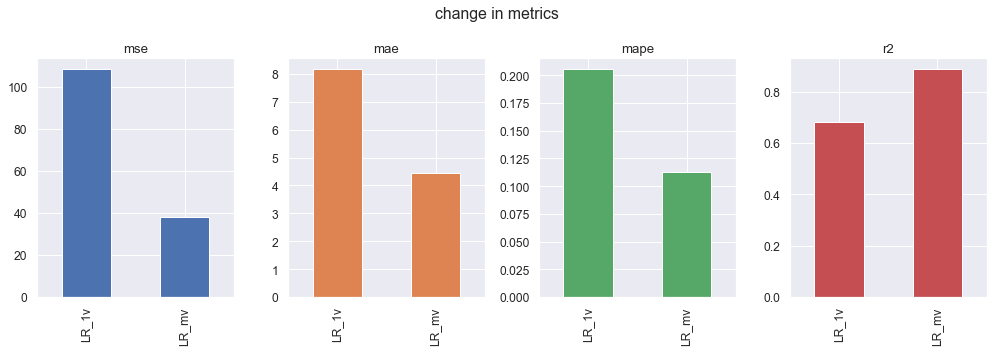

In [2289]:
fig, ax = plt.subplots(figsize=(14, 5))  # specify figure size
metrics_comparison.plot(
    kind='bar', layout=(1,4), subplots=True, 
    title='change in metrics', legend=False, ax=ax
);
fig.tight_layout();  # prettify subplots. read more in documentation if interested

* did our Linear regression model improve after we've added more features?

> Yes, the model has improved. There were fewer gross errors, and the coefficient r2 became closer to 1.

### Task 9. Implement Linear regression model with multiple variables yourself (5 points)

Okay, we've fitted Linear regression model using `sklearn` library. Now let's do the math ourselves!

### Prerequisites

For this task you will need to:
* have basic understanding of Linear algebra (operations with vectors and matrices)
* know how to perform matrix multiplication, transposition and inversion using `numpy` 
  (these functions can be found in NumPy documentation)
* carefully read the theory below and refer to wiki / textbooks / other sources if required

---

### Theory and notation

When we extend Linear regression model on case with $m$ variables we get the following formula:

* $ \hat{y}
= 1 \cdot w_0 + x_1 \cdot w_1 + x_2 \cdot w_2 + ... + x_m \cdot w_m
= \sum_{i=0}^{m} x_i w_i
$,

where:
* $x = (1, x_1, ..., x_m)$ is an _(m+1)_-element feature vector. 
    * $x_0 = 1$ is a special term introduced in the beginning of feature vector 
      to add intercept to Linear regression model
    * $x_i, i=\overline{1,m}$ is an _i_-th feature value.
* $w = (w_0, w_1, ..., w_m)$ is an _(m+1)_-element parameter vector
    * $w_0$ - the first value of parameter vector - is referred to as **intercept**
* $\hat{y}$ is a predicted value

----

The formula above is used to calculate predictions for 1 sample.
i.e. we predict 1 scalar $\hat{y}$ from 1 feature vector $x$.

If we have a dataset of $n$ samples $(x, y)$ - we get a system of linear equations:

$
\begin{cases}
 \hat{y}^{(0)} = \sum_{i=0}^{m} x_i^{(0)} w_i \\
 \hat{y}^{(1)} = \sum_{i=0}^{m} x_i^{(1)} w_i \\
 ... \\\
 \hat{y}^{(n-1)} = \sum_{i=0}^{m} x_i^{(n-1)} w_i
\end{cases}
$

Such system can be rewritten in a succinct matrix form (a way that we write equations in Linear algebra):

* $ \hat{y} = X \cdot w $

And the task of minimizing Residual sum of squares (RSS) now looks:
* $ RSS(w, x, y) = \|y - \hat{y}\|_2^2 = \|y - X \cdot w \|_2^2 \rightarrow min $

Here:
* $y = (y^{(0)}, y^{(1)}, ..., y^{(n-1)})$ now denotes a **vector of target values** we want to predict<br>
  $y^{(j)}$ is a target value for _j_-th sample in a dataset.
* $\hat{y} = (\hat{y}^{(0)}, ..., \hat{y}^{(n-1)})$ 
  now denotes a **vector of predictions** <br>
  $\hat{y}^{(j)}$ denotes a predicted value for _j_-th sample in a dataset
* $X$ is a **feature matrix** of shape $n \times (m+1)$. <br>
  _n_ rows correspond to _n_ data samples and _m+1_ columns correspond to _m+1_ features that describe each sample.
* $w = (w_0, w_1, ..., w_m)$ is still a **model parameter vector**
* $X \cdot w$ denotes a **matrix-by-vector** multiplication
* $\|\cdot\|_2$ denotes an $L_2$-norm and is basically a square root of sum of squares of vector elements:<br>
  $\|a\|_2 = \sqrt{a_0^2 + a_1^2 + ... + a_{n-1}^2}$ for an _n_-component vector _a_.
  Thus, RSS means the same as before:<br>
  $ RSS(w, x, y) = \|y - \hat{y}\|_2^2 = 
  (y^{(0)} - \hat{y}^{(0)})^2 + (y^{(1)} - \hat{y}^{(1)})^2 + ... + (y^{(n-1)} - \hat{y}^{(n-1)})^2 = 
  \sum_{j=0}^{n-1} (y^{(j)} - \hat{y}^{(j)})^2
  $

Note:
* we now use **superscripts** $\hat{y}^{(i)}$ instead of **subscripts** $\hat{y}_i$ as before
  to denote _i_-th sample in a dataset
* it is done to be able to refer both to sample index (denoted by superscript)
  and feature index (denoted by subscript) in a single equation. 
  
  Thus:
  * $x^{(j)} = (1, x^{(j)}_1, x^{(j)}_2, ..., x^{(j)}_{m})$  now denotes 
    _j_-th feature vector in a dataset with _m+1_ features
  * $x_i^{(j)}$ denotes an _i_-th feature value of _j_-th feature vector
  * $X = 
  \begin{bmatrix}
      1 & x^{(0)}_1 & x^{(0)}_2 & ... & x^{(0)}_{m} \\
      1 & x^{(1)}_1 & x^{(1)}_2 & ... & x^{(1)}_{m} \\
      ... \\
      1 & x^{(n-1)}_1 & x^{(n-1)}_2 & ... & x^{(n-1)}_{m}
    \end{bmatrix}
    $ is an $n \times (m+1)$ feature matrix. <br><br>
    $X$ can also be written as a column-vector of feature vectors:<br><br>
    $ X = \begin{bmatrix}x^{(0)} \\ x^{(1)} \\ ... \\ x^{(n-1)}\end{bmatrix} $

---

### Fit 

**<TL;DR\>** Enough notation! How can we fit this model?

By minimizin Residual sum of squares (RSS) for a Linear regression equation in a matrix form
we now get a **single** formula to find **all model parameters**!
* $ w = (X^T X)^{-1} X^T y $

Beautiful, isn't it? <br>
Recall, how we got individual formulas for $w_0, w_1$ in case of Linear regression with 1 predictor.<br>
Now we can find the whole parameter vector _w_ at once!

In the formula above:
* $X$ is an $n \times (m+1)$ dimensional feature matrix


* $X^T$ is a **transposed** feature matrix.<br>
  Transposition is a mathematical operation of "swapping" matrix dimensions.<br>
  So $X^T$ is an $(m+1) \times n$ dimensional matrix  


* $ (X^T X)^{-1} $ is the inverse matrix of $ X^T X $

Notes:
* Because of inversion operation performed on $X^T X$ matrix 
  there are difficulties in fitting Linear regression model in some cases.
  
  We will talk more on that later in the assignment.

---
    
If you want to learn more you can refer to 
[Linear least squares](https://en.wikipedia.org/wiki/Linear_least_squares)
wiki-page.

### Implementation

* implement `LRMatrixForm` class and `add_ones_column` function.<br>
  docstrings describe what each function/method should do - so read the docstrings.
  
  
* [what is a docstring?](https://www.python.org/dev/peps/pep-0257/#what-is-a-docstring)


Note:
* `LRMatrixForm` class must support 2 modes: **with** fitting intercept parameter and **without**.<br>
  The behavior is controlled by `fit_intercept` parameter passed to class constructor.

In [2290]:
from sklearn.exceptions import NotFittedError

In [2291]:
def add_ones_column(x):
    """ 
    Add column consisting of ones to the beginning of matrix `x`. 
    Used when fitting `LRMatrixForm` with `fit_intercept` param set to True.
    """
    # HINTS: 
    # * create a vector that consists of ones: (1, 1, ..., 1)
    # * then use either `np.column_stack` or `np.hstack` function to add this vector to a matrix
    
    # your code here:
    return np.column_stack((np.ones((len(x),1)), x))

class LRMatrixForm:
    """
    Class that encapsulates Linear regression model with multiplie variables.
    Calculations are performed using matrix formula.
    
    Use `fit()` method to fit the model on data.
    Use `predict()` method to calculate predictions when the model is fitted.
    """
    def __init__(self, fit_intercept: bool = True):
        """
        fit_intercept: 
        Whether to calculate the intercept for this model. 
        If set to False, no intercept will be used in calculations 
        (i.e. data is expected to be centered).
        """
        self.fit_intercept = fit_intercept
        self.w_ = None  # vector with all model parameters (intercept and weights)
    
    def fit(self, x_train: pd.DataFrame, y_train: pd.Series):
        X = x_train.to_numpy()  # convert pd.DataFrame to numpy matrix
        
        if self.fit_intercept is True:
            # when creating a model with intercept term we need to extend feature matrix
            # with a column consisting of ones (1, 1, ..., 1).
            X = add_ones_column(X)
            
        # your code here to calculate model parameters:
        self.w_ = np.linalg.inv(X.transpose() @ X) @ X.transpose() @ y_train 
        
    @property
    def coef_(self):
        """ Property that returns model parameters without the intercept term. """
        if self.w_ is None:
            raise NotFittedError()
        # your code here:
        if self.fit_intercept is True:
            return self.w_[1:]
        return self.w_
    
    @property
    def intercept_(self):
        """ Property that returns intercept term from model parameters. """
        if self.fit_intercept is not True:
            return 0.0  # for compatibility with sklearn
        if self.w_ is None:
            raise NotFittedError()
        # your code here:
        return self.w_[0]
    
    def predict(self, x_test: pd.DataFrame):
        """ Generate predictions using fitted model parameters. """
        if self.w_ is None:
            raise NotFittedError()
        
        X = x_test.to_numpy()  # convert pd.DataFrame to numpy matrix
        
        if self.fit_intercept is True:
            X = add_ones_column(X)
            
        # your code here to calculate predictions
        y_test = X @ self.w_
        return y_test

### Validate your implementation is identical to library version

In [2292]:
lr_matrix_form = LRMatrixForm(fit_intercept=True)
fit_and_evaluate(lr_matrix_form, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,37.744076,4.423665,0.109928,0.879145
test,38.192447,4.459334,0.112574,0.887719


In [2293]:
print(f'intercept: {lr_matrix_form.intercept_}')
print(f'coef: {lr_matrix_form.coef_}')

intercept: -4.410760994495641
coef: [ 0.98220522 -0.03927767 -0.14440889  0.20772844]


In [2294]:
assert np.allclose(model.predict(x_test), lr_matrix_form.predict(x_test))
assert round(model.intercept_, 9) == round(lr_matrix_form.intercept_, 9)
assert np.allclose(model.coef_, lr_matrix_form.coef_)

* let's take a look at difference between model predictions and target values:

In [2295]:
(model.predict(x_test) - y_test).describe()

count    2117.000000
mean       -0.000265
std         6.181464
min       -19.832055
25%        -3.624840
50%        -0.929033
75%         2.657819
max        39.721074
Name: dribbling, dtype: float64

### Now let's compare `sklearn` model and yours with `fit_intercept=False`

In [2296]:
model = LinearRegression(fit_intercept=False)
fit_and_evaluate(model, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,38.001048,4.462836,0.111262,0.878322
test,38.417697,4.494385,0.114204,0.887057


In [2297]:
lr_matrix_form = LRMatrixForm(fit_intercept=False)
fit_and_evaluate(lr_matrix_form, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,38.001048,4.462836,0.111262,0.878322
test,38.417697,4.494385,0.114204,0.887057


* Compare the metrics on a test set of a model fitted **with** intercept parameter 
  vs model fitted **without** intercept.
* Which model has a better performance? Can you explain why?

In [2298]:
print(f'intercept: {lr_matrix_form.intercept_}')
print(f'coef: {lr_matrix_form.coef_}')

intercept: 0.0
coef: [ 0.99382995 -0.05758452 -0.17865978  0.18315944]


In [2299]:
assert np.allclose(model.predict(x_test), lr_matrix_form.predict(x_test))
assert round(model.intercept_, 9) == round(lr_matrix_form.intercept_, 9)
assert np.allclose(model.coef_, lr_matrix_form.coef_)

* let's take a look at difference between model predictions and target values again:

In [2300]:
(model.predict(x_test) - y_test).describe()

count    2117.000000
mean        0.069583
std         6.199275
min       -20.437460
25%        -3.706841
50%        -0.888994
75%         2.766454
max        39.316868
Name: dribbling, dtype: float64

* compare this to the same statistics obtained with model fitted **with intercept**
* notice how the _mean_ value of difference changed

In [2301]:
lr_model_with_intercept = LinearRegression()
lr_model_with_intercept.fit(x_train, y_train)
comp_stats = pd.concat([
    (lr_model_with_intercept.predict(x_test) - y_test).describe(),
    (model.predict(x_test) - y_test).describe()
], axis=1)
comp_stats.columns = ['with_intercept', 'without_intercept']
comp_stats

,with_intercept,without_intercept
count,2117.000000,2117.000000
mean,-0.000265,0.069583
std,6.181464,6.199275
min,-19.832055,-20.437460
25%,-3.624840,-3.706841
50%,-0.929033,-0.888994
75%,2.657819,2.766454
max,39.721074,39.316868


> *mean* of model fitted with intercept is closer to 0

## Limitations of Linear regression

Recall the formula to find Linear regression parameters in case of multiple variables:
* $ w = (X^T X)^{-1} X^T y $

As noted above, there might be difficulties with fitting Linear regression model
because of inverting $X^T X$ matrix.

Not every matrix can be inverted.

An example of such case is when 2 or more features have strong linear relationship between them.<br>
It means that one of variables can be **linearly predicted from the others with a substantial degree of accuracy**.<br>
Such situation is named **collinearitry** (in case of 2 related variables)
or **multicollinearity** (>2 related features).<br>

Collinearity is associated with high value of correlation coefficient between 2 related features.

You can refer to [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity) 
wiki page to read more.

The intuition why multicollinearity is bad is that Linear Regression tries to capture 
a contribution of each individual feature to target independently of other features.
This is not possible with the data that has collinear features, 
as change in one such variable is always associated with change in other/others.

There are a whole bunch of really interesting thoughts that can help you 
to capture the intuition behind the concept of multicollinearity.<br>
You can find some of them 
[here](https://stats.stackexchange.com/questions/1149/is-there-an-intuitive-explanation-why-multicollinearity-is-a-problem-in-linear-r).

### Collinearity

* Let's construct and add a new feature to our dataset that is going to be _collinear_ with another one:

In [2302]:
# select features as usual
target = 'dribbling'
features = ['ball_control', 'short_passing', 'strength', 'sprint_speed']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

In [2303]:
def add_collinear_column(_df: pd.DataFrame, orig_col: str, new_col: str):    
    """ 
    Construct new column as a linear transform of another one + tiny noise.
    y = f(x) = a1 * x + a2 + noise.
    
    Alternatively, we could apply no linear transform at all (set a1=1, a2=0)
    And only add some noise to existing column. Results would be the same.
    """
    # linear transform
    _df[new_col] = 2 * _df[orig_col] + 3
    # add tiny normal noise
    _df[new_col] += np.random.normal(loc=0, scale=0.0001, size=_df.shape[0])

orig_col = 'sprint_speed'
new_col = 'sprint_speed_2'
add_collinear_column(x_train, orig_col, new_col)
add_collinear_column(x_test, orig_col, new_col)
features.append(new_col)

In [2304]:
corr_coef = np.corrcoef(x_train[orig_col], x_train[new_col])[0, 1]
print(f'correlation between {orig_col} and {new_col}: {corr_coef}')

correlation between sprint_speed and sprint_speed_2: 0.999999999993592


* As expected, correlation coefficient between collinear features 
  (`sprint_speed` and `sprint_speed_2`) is close to 1.<br>
  Thus they are highly correlated.

In [2305]:
# visualize sample of train data
check = x_train.sample(5).copy()
# add helper column to see how much noise was added
check['sprint_speed_2_wo_noise'] = 2 * check['sprint_speed'] + 3
check

,ball_control,short_passing,strength,sprint_speed,sprint_speed_2,sprint_speed_2_wo_noise
38595,68.0,61.0,49.0,85.0,173.000006,173.0
93595,57.0,64.0,90.0,63.0,129.000053,129.0
94116,38.0,38.0,78.0,60.0,123.000208,123.0
16694,62.0,60.0,58.0,71.0,145.000167,145.0
100898,63.0,56.0,86.0,65.0,132.999962,133.0


### let's fit a Linear Regression model on this feature set:

In [2306]:
model = LinearRegression(fit_intercept=True)
fit_and_evaluate(model, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,37.727083,4.423872,0.109919,0.87920
test,38.239841,4.460245,0.112636,0.88758


* Both train and test metrics look reasonable
* Now let's explore model params:

In [2307]:
print(f'intercept: {model.intercept_}')
print(f'coef: {model.coef_.tolist()}')

intercept: -3928.6401436287942
coef: [0.9823143446870772, -0.03937193798119846, -0.14454128698994204, -2615.946856447835, 1308.077320052216]


* Weights that correspond to `sprint_speed` and `sprint_speed_2` columns should have gone insanely high!


* That is not ok. Large weights and weights instability are the sign of 
    [**overfitting**](https://en.wikipedia.org/wiki/Overfitting).

    According to the definition, overfitting is:<br>
    "_the production of an analysis that corresponds too closely 
    or exactly to a particular set of data,<br>
    and may therefore fail to fit additional data 
    or predict future observations reliably_".
    
    
* But what does that mean? Let's try to generate predictions with our model.

### generate predictions using our fitted model

In [2308]:
check = x_test.head(2).copy()
check[target] = y_test.head(2)
check['preds'] = model.predict(check[features])
check

,ball_control,short_passing,strength,sprint_speed,sprint_speed_2,dribbling,preds
147541,51.0,60.0,68.0,52.0,106.999972,49.0,44.266554
147549,65.0,69.0,66.0,69.0,140.999981,59.0,61.498654


In [2309]:
get_metrics(y_true=check[target], y_pred=check['preds'])

mse     14.324392
mae      3.616050
mape     0.069476
r2       0.427024
dtype: float64

* predictions look good, right? 

### but what if we change `sprint_speed` values a bit? let's add some small `delta`

In [2310]:
delta = 1  # some small value
check['sprint_speed'] += delta
check['preds_2'] = model.predict(check[features])
check

,ball_control,short_passing,strength,sprint_speed,sprint_speed_2,dribbling,preds,preds_2
147541,51.0,60.0,68.0,53.0,106.999972,49.0,44.266554,-2571.680302
147549,65.0,69.0,66.0,70.0,140.999981,59.0,61.498654,-2554.448202


In [2311]:
get_metrics(y_true=check[target], y_pred=check['preds_2'])

mse     6.849038e+06
mae     2.617064e+03
mape    4.888950e+01
r2     -2.739605e+05
dtype: float64

* Wow, new predictions doesn't look even close to the target!<br>
  Our model doesn't look like a good model anymore.
  

* That is exactly what overfitting is. <br>
  **We fail to obtain reasonable predictions when we apply our model on new data**.

### One might notice that we have changed only 1 of 2 collinear features
* Indeed, giant model weights that correspond to these 2 features, should cancel each one out<br>
  if relation between feature values stays the same.  

* Let's check this out.<br>
  We have performed following transform:<br>
  `sprint_speed_changed = sprint_speed + delta`<br>
  

* How should we change `sprint_speed_2` to match the same data distribution from train data?<br>
  
  Let's calculate (we will ignore the noise added):  
  `sprint_speed_2_changed - sprint_speed_2 = f(sprint_speed_changed) - f(sprint_speed) =`<br>
  `= a1 * sprint_speed_changed + a2 - (a1 * sprint_speed + a2) = a1 * delta`

In [2312]:
# here we change the second of collinear features 
# using the same coefficient 
# that was used in linear transform in `add_collinear_column()` function.
# we don't need to add intercept coefficient as it cancels it out (you can do the math yourself).
check['sprint_speed_2'] += 2 * delta
check['preds_3'] = model.predict(check[features])
check

,ball_control,short_passing,strength,sprint_speed,sprint_speed_2,dribbling,preds,preds_2,preds_3
147541,51.0,60.0,68.0,53.0,108.999972,49.0,44.266554,-2571.680302,44.474338
147549,65.0,69.0,66.0,70.0,142.999981,59.0,61.498654,-2554.448202,61.706438


* In the last example we see that new predictions (`preds_3`) now look similar to the first ones <br>
  (`preds` - calculated before changing `sprint_speed` value)


* So, if values of collinear features change accordingly - we are safe, right? <br>
  How do your think, can we always rely on this assumtion?

> No, we can't. Unseen data won't necessarily follow the same pattern, and with the big coefficients predictions will be far from good.

### What just happened

* The answer to the question above is: **no, we can't**.
  
  
* Yes, we have checked that if collinear features values are changed accordingly 
  (i.e. their **initial relation is preserved**), <br>
  model predictions look reasonable and accurate.
  
  But this will not always be the case on the real data.
  
  We can't be sure that the data 
  that we apply our fitted model on (`x_test`, for example)<br>
  preserves **exactly the same data distribution** as the data that model was trained on (`x_train`).
  
  

**Why this happened?**

* When feature matrix contains collinear or multicollinear features (the problem of **multicollinearity**),
  inversion of such a matrix is numerically unstable.<br>
  This leads to large values and imprecise estimates of model parameters.

**How to detect multicollinearity**
* You should monitor your model weights. For example using $L_2$ norm:<br>
  $ L_2(w) = \|w\|_2 = \sqrt{w_1^2 + w_2^2 + ... + w_n^2} = \sqrt{\sum_{i=1}^{n} w_i^2} $<br>
  If any of model weights are huge - $L_2$ norm will also have large value.
  
  
* Monitor model performance on validation data. 
  If the metrics are poor and prediction look huge,<br>
  you should check if collinear features are present in train data.

**How to fix the issue**

* For each set of collinear features, keep only 1 of them and remove the rest.<br>
  The best regression models are those in which the predictor variables each correlate highly 
  with the target variable,<br>
  but correlate at most only minimally with each other.
  

* Combine collinear features into new ones

  
* Use regularization (will be covered later in the course).

### Task 10. Implement function to calculate $L_2$-norm. (1 point)
* Use formula above to implement $L_2$ norm

In [2313]:
def l2_norm(arr: Iterable):
    # your code here
    return np.sqrt(np.sum(np.square(arr)))

### Calculate $L_2$-norm value for current model
* you should get high value that represents large values of some model parameters

In [2314]:
l2_norm(model.coef_)

2924.764130383526

### Multicollinearity
  
* It's important to notice that in case of multicollinearity,
  correlation coefficient between each pair of related variables
  could be **not so high**.
  
  So **it may be hard to find multicollinear features in your data**.
  

* Let's visualize it in practice.

  We will build a new feature that has a strong linear relationship with 2 other features:
  $x_1 = a_0 + a_2 x_2 + a_3 x_3 + noise$

  We want to show that Linear regression model will still suffer from multicollinearity,<br>
  but correlation coefficients betweent each pair of multicollinear features will be **less close to 1**
  than it was in case of collinearity.

In [2315]:
target = 'dribbling'
features = ['ball_control', 'short_passing', 'strength', 'sprint_speed']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

def add_collinear_column(_df: pd.DataFrame, col1: str, col2: str, new_col: str):    
    _df[new_col] = _df[col1] + _df[col2] + 5
    _df[new_col] += np.random.normal(loc=0, scale=0.0001, size=_df.shape[0])

add_collinear_column(x_train, col1='sprint_speed', col2='strength', new_col='foo')
add_collinear_column(x_test, col1='sprint_speed', col2='strength', new_col='foo')
features.append(new_col)

model = LinearRegression(fit_intercept=True)
m = fit_and_evaluate(model, x_train, y_train, x_test, y_test)
display(m)
print(f'intercept: {model.intercept_}')
print(f'coef: {model.coef_.tolist()}')

,mse,mae,mape,r2
train,37.739985,4.422219,0.109903,0.879158
test,38.198966,4.459799,0.112559,0.887700


intercept: 3176.735603583378
coef: [0.9820536525525887, -0.03910316439676869, 636.0870617870144, 636.4392125939256, -636.2314058526451]


* As before, model parameters for multicollinear features should be large

* Let's calculate $L_2$-norm value - it should also be large

In [2316]:
l2_norm(model.coef_)

1102.022227204007

#### Task 11. Visualize correlation matrix for `x_train`  (1 point)
* Build annotated heatmap (use `annot` param to add values to plot, select diverging `cmap` and center it at 0)
* You should see that `foo` feature is correlated with ones it was created from,<br>
  but each of these correlation coefficients **is not so close to 1**

,ball_control,short_passing,strength,sprint_speed,foo
ball_control,1.000000,0.904857,-0.024422,0.572677,0.474099
short_passing,0.904857,1.000000,0.039196,0.450801,0.415056
strength,-0.024422,0.039196,1.000000,-0.203386,0.541851
sprint_speed,0.572677,0.450801,-0.203386,1.000000,0.712702
foo,0.474099,0.415056,0.541851,0.712702,1.000000


<AxesSubplot:>

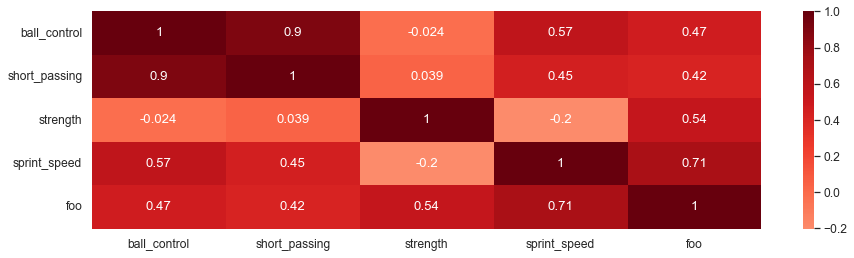

In [2317]:
# your code here
correlation_matrix=x_train.corr()
display(correlation_matrix)


plt.figure(figsize=(15, 4))
sns.heatmap(correlation_matrix, center=0, cmap=plt.cm.Reds, annot=True)

### Regularization

* The concept of regularization (that was mentioned above) is simple.

  We modify Loss function (RSS in case of Linear regression) in such a way<br>
  to penalize for large values of model parameters.
  
  
* $L_2$ regularization, also named as 
  [Tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization), 
  adds $L_2$ term to loss function:

  $L(w,x,y) = RSS(w,y) + \alpha L_2(w) = \|y - \hat{y}\|_2^2 + \alpha \|w\|_2^2 
  = \|y - X \cdot w \|_2^2 + \alpha \|w\|_2^2$
  
  parameter $ \alpha \ge 0 $ controls the ammount of regularization applied
  

* Linear regression implemented with $L_2$ regularization is named a **Ridge regression**.


* Ridge regression is implemented in `Ridge` class in `sklearn` library

---

Let's see how applying regularization changes our model.

In [2318]:
from sklearn.linear_model import Ridge

* at first fit `Ridge` without any regularization to ensure we get similar results 
  to using `LinearRegression`

In [2319]:
# `solver` parameters determines the algorithm used to solve regression task.
# we fix it to be `svd` to achieve desired results.
model_r = Ridge(alpha=0, fit_intercept=True, solver='svd')
fit_and_evaluate(model_r, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,37.739985,4.422219,0.109903,0.879158
test,38.198966,4.459799,0.112559,0.887700


In [2320]:
print(f'intercept: {model_r.intercept_}')
print(f'coef: {model_r.coef_.tolist()}')
print(f'l2 norm: {l2_norm(model_r.coef_)}')

intercept: 3176.7356035834073
coef: [0.9820536525525885, -0.03910316439676664, 636.0870617870166, 636.439212593928, -636.2314058526476]
l2 norm: 1102.0222272040112


* some model parameters should be large, as well as the $L_2$-norm value
* now, let's add some regularization

In [2321]:
model_r = Ridge(alpha=0.01, fit_intercept=True, solver='svd')
fit_and_evaluate(model_r, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,37.744053,4.423660,0.109928,0.879145
test,38.192453,4.459334,0.112574,0.887719


In [2322]:
print(f'intercept: {model_r.intercept_}')
print(f'coef: {model_r.coef_.tolist()}')
print(f'l2 norm: {l2_norm(model_r.coef_)}')

intercept: 4.529885937714305
coef: [0.9822047757878285, -0.039277151774084695, 1.6437262720792547, 1.9958636436147745, -1.7881350031290904]
l2 norm: 3.2937825439871076


* notice how parameter values changed
* also notice how $L_2$-norm values decreased

> All parameters are not so big, and l2-norm decreased

## Task 12. Putting all together. (up to 10 points)

In the final task we'll try to recap all that we have learnt so far.

Your task is to build a Linear regression model with multiple variables to predict `agility` variable.<br>
Only `LinearRegression` class is allowed to be used for modeling.<br>

Steps you need to follow:

* Make a new train/test split with new proportion: 70% on train and 30% on test data **(1 point)**


* Fit a model **(up to 6 points)**
    
    * Choose >= 10 features from training set as initial set of features
      Explain your choice. **(1 point)**
      
    * Visualize correlation matrix for selected features **(1 point)**
    
    * Analyze if collinear/multicollinear features are present in your feature set.<br>
      Process collinear/multicollinear features if they are present:<br>
      remove redundant features, combine features into new ones, etc **(up to 3 points)**
     
    * Fit the model and calculate metrics on train and test sets<br>
      **(1 point max. -0.25 points per each metric that was not implemented in the beginning of the assignment)**
    

* Analyze fitted model performance **(up to 2 points)**:
    * Print fitted model parameters and calculate their $L_2$-norm value **(1 point)**
    * Make conclusion whether your model overfitted or not. Provide your arguments. **(1 point)**


* Write a short report about the work done **(1 point)**<br>
  Can you find a logical explanation for high correlation of some of your features?<br>
  Are you satisfied with the quality of predictions?<br>
  How could you pottentially improve the model?<br>
  Any other thoughts.


**Penalties:**
- **0 points are assigned for the whole task** if used a model different from:
    - `sklearn.linear_model.LinearRegression`
    - or `LRMatrixForm`

> *Make a new train/test split with new proportion (70/30)*


In [2323]:
print(df.shape)
ix_split = int(0.7 * df.shape[0])
DF_TRAIN = df.iloc[:ix_split].copy()
DF_TEST = df.iloc[ix_split:].copy()
print(DF_TRAIN.shape, DF_TEST.shape)

(10582, 35)
(7407, 35) (3175, 35)


> *Choosing features:*

In [2324]:
df.columns

Index(['overall_rating', 'potential', 'crossing', 'finishing',
       'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve',
       'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration',
       'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power',
       'jumping', 'stamina', 'strength', 'long_shots', 'aggression',
       'interceptions', 'positioning', 'vision', 'penalties', 'marking',
       'standing_tackle', 'sliding_tackle', 'gk_diving', 'gk_handling',
       'gk_kicking', 'gk_positioning', 'gk_reflexes'],
      dtype='object')

In [2325]:
target = 'agility'
df.corr()[target]

overall_rating        0.215998
potential             0.267011
crossing              0.618485
finishing             0.553901
heading_accuracy      0.089995
short_passing         0.521943
volleys               0.547171
dribbling             0.713123
curve                 0.611963
free_kick_accuracy    0.503993
long_passing          0.426705
ball_control          0.625814
acceleration          0.797346
sprint_speed          0.730343
agility               1.000000
reactions             0.252051
balance               0.742262
shot_power            0.463734
jumping               0.185940
stamina               0.482563
strength             -0.408930
long_shots            0.555267
aggression            0.055090
interceptions        -0.029564
positioning           0.620826
vision                0.550416
penalties             0.459486
marking              -0.085376
standing_tackle      -0.048907
sliding_tackle       -0.043100
gk_diving            -0.402478
gk_handling          -0.398713
gk_kicki

> Visualize a correlation matrix of features and take 10 or more of the most correlated features with target value.

In [2326]:
correlation_matrix = df.corr()
correlation_matrix

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
overall_rating,1.000000,0.815249,0.293684,0.266877,0.236246,0.412008,0.304024,0.296112,0.326502,0.283547,0.392166,0.380553,0.174668,0.188511,0.215998,0.787206,0.100119,0.347885,0.233605,0.241977,0.215589,0.326083,0.269096,0.203424,0.285609,0.409411,0.278143,0.122011,0.152052,0.134891,0.029723,0.032112,0.028797,0.032090,0.032358
potential,0.815249,1.000000,0.242029,0.244247,0.165555,0.367661,0.248509,0.317433,0.268560,0.204085,0.320514,0.365276,0.299818,0.309311,0.267011,0.602781,0.161929,0.274228,0.172163,0.233792,0.065608,0.265409,0.146234,0.121259,0.256299,0.349201,0.215750,0.068372,0.097823,0.089100,-0.008990,-0.008277,-0.011134,-0.011421,-0.007122
crossing,0.293684,0.242029,1.000000,0.602687,0.402634,0.803246,0.654547,0.829761,0.817277,0.732209,0.744029,0.827153,0.576943,0.556556,0.618485,0.311563,0.577861,0.683626,0.048116,0.584142,-0.136503,0.729019,0.377988,0.329211,0.727912,0.691808,0.620951,0.274110,0.324442,0.312264,-0.654603,-0.651642,-0.647341,-0.654693,-0.656178
finishing,0.266877,0.244247,0.602687,1.000000,0.394889,0.609391,0.870419,0.789398,0.711735,0.657718,0.421171,0.738709,0.501686,0.481219,0.553901,0.291960,0.423846,0.749742,0.014281,0.376077,-0.085452,0.826329,0.106609,-0.175514,0.870469,0.677950,0.795875,-0.248159,-0.186195,-0.224519,-0.519915,-0.513952,-0.516438,-0.519262,-0.520261
heading_accuracy,0.236246,0.165555,0.402634,0.394889,1.000000,0.579282,0.406924,0.448041,0.356718,0.338306,0.456997,0.589430,0.156921,0.225398,0.089995,0.203711,0.057231,0.581341,0.247838,0.492828,0.458682,0.428385,0.638928,0.475335,0.422624,0.287898,0.477403,0.481460,0.505468,0.466825,-0.734214,-0.732242,-0.726710,-0.730981,-0.732507
short_passing,0.412008,0.367661,0.803246,0.609391,0.579282,1.000000,0.652236,0.812938,0.755942,0.715015,0.880310,0.905642,0.465631,0.452852,0.521943,0.394963,0.490882,0.746555,0.075297,0.618040,0.032031,0.745760,0.512571,0.458404,0.707954,0.755552,0.660161,0.385064,0.451078,0.411326,-0.736448,-0.732403,-0.728134,-0.734203,-0.733630
volleys,0.304024,0.248509,0.654547,0.870419,0.406924,0.652236,1.000000,0.784317,0.760770,0.708657,0.495958,0.755249,0.470034,0.448022,0.547171,0.335563,0.442740,0.768610,0.021653,0.388391,-0.072783,0.836513,0.178628,-0.066498,0.835576,0.703066,0.786152,-0.148167,-0.082637,-0.117229,-0.531869,-0.527925,-0.528407,-0.532203,-0.532171
dribbling,0.296112,0.317433,0.829761,0.789398,0.448041,0.812938,0.784317,1.000000,0.822143,0.723443,0.666167,0.920367,0.685186,0.655831,0.713123,0.301088,0.606836,0.763753,0.053865,0.584423,-0.155298,0.815342,0.288671,0.140436,0.857636,0.735684,0.723614,0.079198,0.142647,0.117572,-0.707677,-0.702359,-0.700129,-0.705065,-0.705573
curve,0.326502,0.268560,0.817277,0.711735,0.356718,0.755942,0.760770,0.822143,1.000000,0.827755,0.675309,0.812113,0.519488,0.483456,0.611963,0.343713,0.541798,0.728929,0.005761,0.481505,-0.153595,0.806222,0.266032,0.161390,0.773694,0.736275,0.717838,0.082268,0.144385,0.117374,-0.584544,-0.580548,-0.579310,-0.586157,-0.586084
free_kick_accuracy,0.283547,0.204085,0.732209,0.657718,0.338306,0.715015,0.708657,0.723443,0.827755,1.000000,0.670172,0.736099,0.391320,0.354244,0.503993,0.310799,0.464484,0.718736,-0.029241,0.423234,-0.102380,0.797479,0.283667,0.190194,0.690948,0.714660,0.717091,0.107587,0.170238,0.134160,-0.544635,-0.541333,-0.538959,-0.544079,-0.544443


> Let's leave only correlations with targer value and sort them, so we can see which features had the highest correlation with "agility".

In [2327]:
corr_matrix_agility = correlation_matrix[['agility']]
corr_matrix_agility_sorted = corr_matrix_agility.sort_values(by=['agility'], ascending=False)
corr_matrix_agility_sorted = corr_matrix_agility_sorted.drop('agility')
corr_matrix_agility_sorted

,agility
acceleration,0.797346
balance,0.742262
sprint_speed,0.730343
dribbling,0.713123
ball_control,0.625814
positioning,0.620826
crossing,0.618485
curve,0.611963
long_shots,0.555267
finishing,0.553901


> Is no really strong correlation of higher than 0.8 or lower -0.8 with agility. Let's examine 13 features with highest correlation (moderate and high) 
> from logical point of view (they have correlation higher than 0.5 or lower than -0.5) using describe "agility"
> 
> *Agility* - This characteristic reflects the player's ability to quickly interact (stop / turn) with the ball, as well as make complex shots that require 
> some acrobatic skills (volleyball). Also, this skill affects the quality of the performance of feints.
> 
> Let's choose following features:


In [2328]:
features = list(corr_matrix_agility_sorted.head(13).index)

cols = features + [target]
cols

['acceleration',
 'balance',
 'sprint_speed',
 'dribbling',
 'ball_control',
 'positioning',
 'crossing',
 'curve',
 'long_shots',
 'finishing',
 'vision',
 'volleys',
 'short_passing',
 'agility']

> Fit the model and calculate metrics on train and test sets.

In [2329]:
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

model_13 = LinearRegression(fit_intercept=True)
result = model_13.fit(x_train, y_train)

model_13_predict = model_13.predict(x_test)
model_13_predict

print('model metrics on test')
metrics_init = get_metrics(y_true=y_test, y_pred=model_13_predict)
metrics_init


model metrics on test


mse     49.446261
mae      5.285464
mape     0.095333
r2       0.749379
dtype: float64

In [2330]:
print(f'intercept: {model_13.intercept_}')
print(f'coef: {model_13.coef_.tolist()}')

intercept: 5.776218790539836
coef: [0.392763548205685, 0.31201122133194314, 0.06111855168986806, 0.13332283057451771, -0.04533891324868415, 0.009994498838975019, -0.023754609192461938, 0.07652786734259201, -0.02053066389498739, 0.0024844721615450266, 0.11880389895735123, 0.007638028722332024, -0.08333228359638131]


In [2331]:
print(f'l2-norm: {l2_norm(model_13.coef_)}')

l2-norm: 0.5506774198115033


> Some of features that are highly correlated with target have higher coefficients than features that are less correlated with target. It happened
> because this features higly correlates beetwen each other and, thus, doesn't contribute much to our target.
> 
> There are no large weights of coeffitients and L2 less than one. It means that the model isn't overfitting. And r2 coefficient goes to the 
> one that means good score and goodness of fit.

> Visualize correlation matrix for selected features.

<AxesSubplot:>

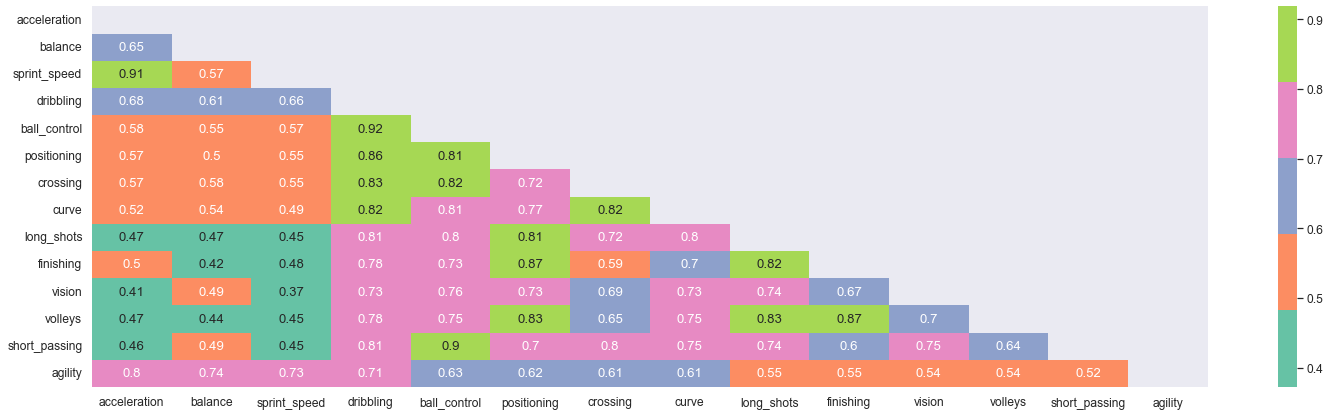

In [2332]:
corr_matrix = DF_TRAIN[cols].corr()

plt.figure(figsize=(25, 7))
matrix = np.triu(corr_matrix)
sns.heatmap(corr_matrix, center=0.81, cmap=plt.cm.Set2, annot=True, mask=matrix)

> Analyze if collinear/multicollinear features are present in your feature set.

> The correlation matrix above for the numeric features indicates a high correlation. For example, 0.92 and 0.91 between (dribbling, ball_control) and 
> (sprint_speed, acceleration) respectively. All areas highlighted in light green. This indicates a possible problem of multicollinearity and the need for 
> further investigation.
>
> Correlation between a ‘predictor and response’ is a good indication of better predictability. But, correlation ‘among the predictors’ is a problem 
> to be rectified to be able to come up with a reliable model.

> What can be done?
> 1. Drop redundant variables or the one with high correlation (or high variance inflation factor (VIF)), but this may again lead to loss of information
> 2. Come up with interaction terms or polynomial terms and drop the redundant features

In [2334]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(df):
    vif_data = pd.DataFrame()
    vif_data['feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data.sort_values(by='VIF', ascending=False)

In [2335]:
# VIF
calc_vif = DF_TRAIN[cols].iloc[:, :-1]
compute_vif(calc_vif)

,feature,VIF
4,ball_control,224.811835
0,acceleration,156.663026
12,short_passing,135.085975
2,sprint_speed,132.487774
3,dribbling,119.438373
5,positioning,56.415431
6,crossing,50.273484
9,finishing,49.764767
10,vision,49.320340
8,long_shots,47.681177


> Clearly, the VIF of 'ball_control' is higher than the other features. We first remove the one with the highest VIF and calculate the VIFs again.

> As the number of features is high, we'll try first find and eliminate the predictors with a very high absolute correlation like > 0.81
> - 'sprint_speed' positively and highly (0.91) correlated with 'acceleration'. Let'c combine them into one feature 'speed&accel'  
> - 'ball_control' positively and highly (0.92) correlated with 'dribbling'. Let'c  drop 'ball_control' (he best regression models are those in 
> which the predictor variables each correlate highly with the target variable, but correlate at most only minimally with each other)

<AxesSubplot:>

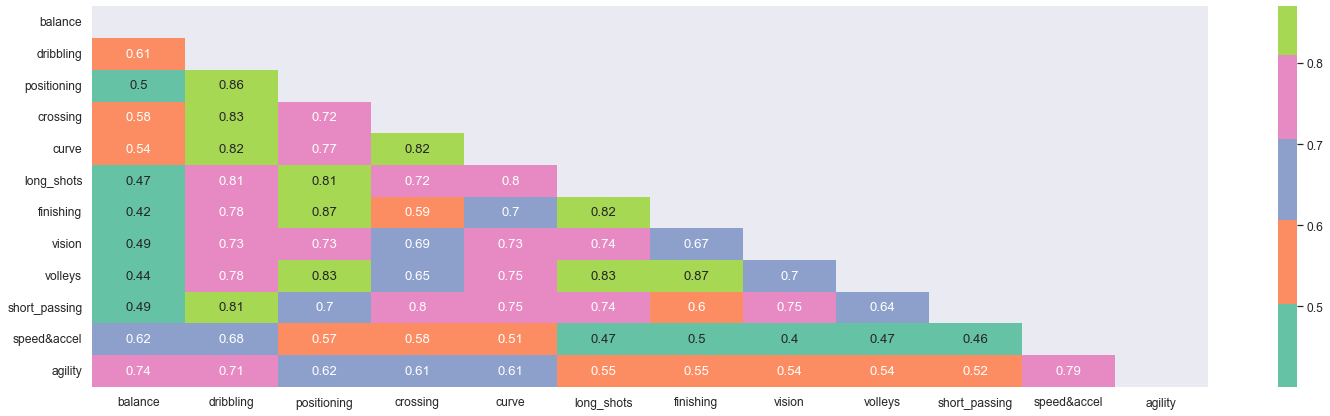

In [2336]:
features_copy = features.copy()

DF_TRAIN['speed&accel'] = (DF_TRAIN['sprint_speed'] + DF_TRAIN['acceleration']) / 2
DF_TEST['speed&accel'] = (DF_TEST['sprint_speed'] + DF_TEST['acceleration']) / 2

features_copy.append('speed&accel')
features_copy.remove('acceleration')
features_copy.remove('sprint_speed')

features_copy.remove('ball_control')
#features_copy.remove('short_passing')
#features_copy.remove('long_shots')
#features_copy.remove('volleys')
#features_copy.remove('curve')
#features_copy.remove('crossing')
#features_copy.remove('finishing')

cols_copy = features_copy + [target]
corr_matrix_new = DF_TRAIN[cols_copy].corr()

plt.figure(figsize=(25, 7))
matrix = np.triu(corr_matrix_new)
sns.heatmap(corr_matrix_new, center=0.81, cmap=plt.cm.Set2, annot=True, mask=matrix)

In [ ]:
# VIF
calc_vif = DF_TRAIN[cols_copy].iloc[:, :-1]
compute_vif(calc_vif)

,feature,VIF
1,dribbling,88.400063
2,positioning,56.057200
6,finishing,48.770369
3,crossing,47.382736
5,long_shots,46.508479
8,volleys,43.897306
9,speed&accel,42.962043
4,curve,41.901185
0,balance,41.188105
7,vision,38.220954


> Simply removing 'ball_control' and  from the data frame lowered the VIF of the other variables, but they are still quite high.

> Fit the model and calculate metrics

In [ ]:
x_train, y_train, x_test, y_test = get_train_test_data(features_copy, target)

model_13 = LinearRegression(fit_intercept=True)
model_13.fit(x_train, y_train)

model_13_predict = model_13.predict(x_test)
model_13_predict

print('model metrics on test')
metrics_fchange = get_metrics(y_true=y_test, y_pred=model_13_predict)
metrics_fchange

model metrics on test


mse     51.361778
mae      5.387789
mape     0.097219
r2       0.739670
dtype: float64

In [ ]:

print(f'intercept: {model_13.intercept_}')
print(f'coef: {model_13.coef_.tolist()}')

intercept: 2.3236352818619395
coef: [0.3402877860189432, 0.07906381964037862, 0.008010654917387075, -0.05766376986598429, 0.07919498579909606, -0.03562194074836277, 0.015913612042649888, 0.09544636136048225, 0.008086684017129104, 0.4537390679076845]


In [ ]:

print(f'l2-norm: {l2_norm(model_13.coef_)}')

l2-norm: 0.5901565058735597


In [ ]:

# Fit the model and calculate metrics
model = LinearRegression(fit_intercept=True)

x_train, y_train, x_test, y_test = get_train_test_data(features, target)
metrics_init = fit_and_evaluate(model, x_train, y_train, x_test, y_test)

x_train, y_train, x_test, y_test = get_train_test_data(features_copy, target)
metrics_fchange = fit_and_evaluate(model, x_train, y_train, x_test, y_test)

pd.DataFrame([metrics_init.loc['test'], metrics_metrics_fchange.loc['test']], index=['features_initial', 'features_collinear'])

,mse,mae,mape,r2
features_initial,49.446261,5.285464,0.095333,0.749379
features_collinear,51.361778,5.387789,0.097219,0.739670


> Model metrics look a little worse. But L2 is within the normal range and parameter values intersept and slope coeffitients on't fdly away. 
> 
> Let'c  drop 'dribbling' (remove the one with the highest VIF and calculate the VIFs again)

<AxesSubplot:>

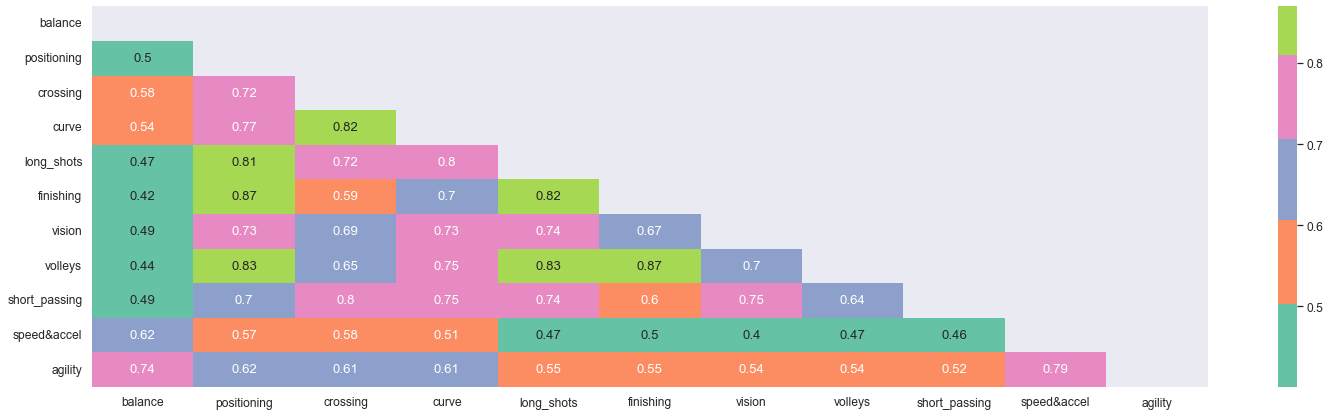

In [ ]:
features_copy.remove('dribbling')

cols_copy = features_copy + [target]
corr_matrix_new = DF_TRAIN[cols_copy].corr()

plt.figure(figsize=(25, 7))
matrix = np.triu(corr_matrix_new)
sns.heatmap(corr_matrix_new, center=0.81, cmap=plt.cm.Set2, annot=True, mask=matrix)

In [ ]:
# VIF
calc_vif = DF_TRAIN[cols_copy].iloc[:, :-1]
compute_vif(calc_vif)

,feature,VIF
8,short_passing,65.163229
1,positioning,52.594793
6,vision,48.928131
5,finishing,48.215449
4,long_shots,47.518530
2,crossing,46.404864
7,volleys,43.843021
0,balance,41.638984
3,curve,41.150606
9,speed&accel,40.549041


In [ ]:
x_train, y_train, x_test, y_test = get_train_test_data(features_copy, target)

model_13 = LinearRegression(fit_intercept=True)
model_13.fit(x_train, y_train)

model_13_predict = model_13.predict(x_test)
model_13_predict

print('model metrics on test')
metrics_fchange2 = get_metrics(y_true=y_test, y_pred=model_13_predict)
metrics_fchange2

model metrics on test


mse     50.983999
mae      5.391484
mape     0.097116
r2       0.741585
dtype: float64

In [ ]:
x_train, y_train, x_test, y_test = get_train_test_data(features_copy, target)
metrics_fchange2 = fit_and_evaluate(model, x_train, y_train, x_test, y_test)

pd.DataFrame([metrics_init.loc['test'], metrics_fchange.loc['test'], metrics_fchange2.loc['test']], index=['features_initial', 'features_collinear', 'features_collinear2'])

,mse,mae,mape,r2
features_initial,49.446261,5.285464,0.095333,0.749379
features_collinear,51.361778,5.387789,0.097219,0.739670
features_collinear2,50.983999,5.391484,0.097116,0.741585


In [ ]:
print(f'intercept: {model_13.intercept_}')
print(f'coef: {model_13.coef_.tolist()}')

intercept: 3.365629897486734
coef: [0.3421140402953903, 0.02796344310289415, -0.010026963237259035, 0.08920260214373552, -0.016472206711110084, 0.018695445909920144, 0.12423100345799454, 0.009479586621494163, -0.07869864243337735, 0.4740640472016763]


In [ ]:
print(f'l2-norm: {l2_norm(model_13.coef_)}')

l2-norm: 0.6107011299996655


> Model metrics look a little better. L2 is within the normal range and parameter values intersept and slope coeffitients don't fly away. 
> 
> Let'c  drop 'short_passing' (remove the one with the highest VIF and calculate the VIFs again)' (remove the one with the highest VIF and calculate the VIFs again)

<AxesSubplot:>

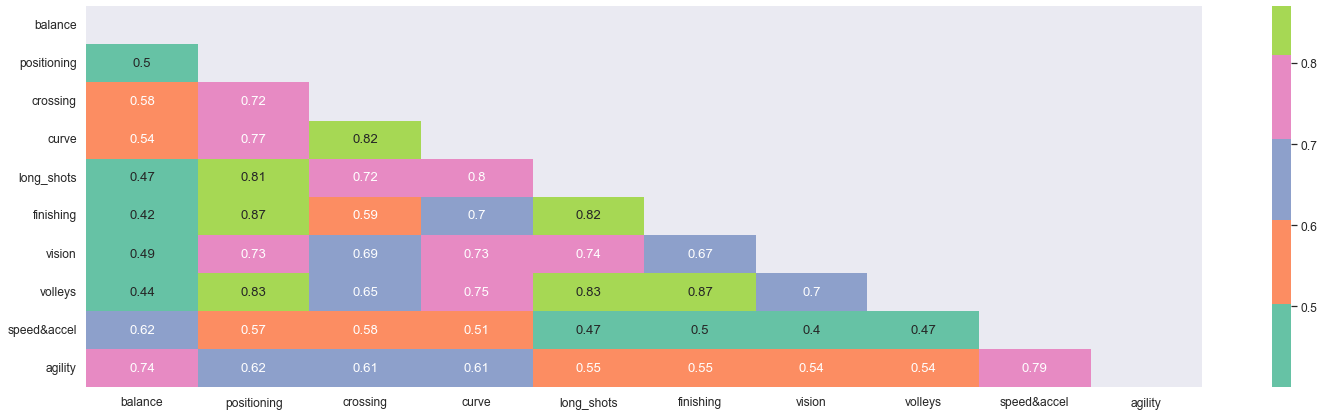

In [ ]:
features_copy.remove('short_passing')

cols_copy = features_copy + [target]
corr_matrix_new = DF_TRAIN[cols_copy].corr()

plt.figure(figsize=(25, 7))
matrix = np.triu(corr_matrix_new)
sns.heatmap(corr_matrix_new, center=0.81, cmap=plt.cm.Set2, annot=True, mask=matrix)

In [ ]:
# VIF
calc_vif = DF_TRAIN[cols_copy].iloc[:, :-1]
compute_vif(calc_vif)

,feature,VIF
1,positioning,52.593920
5,finishing,47.768008
4,long_shots,46.059063
7,volleys,43.842995
2,crossing,41.503323
0,balance,41.176802
3,curve,41.150262
8,speed&accel,38.626928
6,vision,38.166663


In [ ]:
x_train, y_train, x_test, y_test = get_train_test_data(features_copy, target)

model_13 = LinearRegression(fit_intercept=True)
model_13.fit(x_train, y_train)

model_13_predict = model_13.predict(x_test)
model_13_predict

print('model metrics on test')
metrics_fchange2 = get_metrics(y_true=y_test, y_pred=model_13_predict)
metrics_fchange2

model metrics on test


mse     51.559795
mae      5.410662
mape     0.097529
r2       0.738667
dtype: float64

In [ ]:
print(f'intercept: {model_13.intercept_}')
print(f'coef: {model_13.coef_.tolist()}')

intercept: 1.794148817051692
coef: [0.3438929097549102, 0.023110024357827413, -0.03692437572149425, 0.08632631349166693, -0.029169062758329922, 0.025302789201412147, 0.10166649212808909, 0.010858254917964797, 0.47403775481169436]


In [ ]:
print(f'l2-norm: {l2_norm(model_13.coef_)}')

l2-norm: 0.6035469196350676


> Model metrics look a little worse. But L2 is within the normal range and parameter values intersept and slope coeffitients aren't high.
> 
> You need to continue to make the remaining features linearly uncorrelated before moving on to the model training step. But analysis shows that last sets
> gives the metrics, who they turned out to be not much better than simply using all features.

#### Total conclusion

> The model is not retrained. Firstly, because of the small weights of the coefficients, and secondly, because of the small coefficient
> L2, also the predicted values are close to the real ones, the metrics show this.
>
> There are many features that have a high correlation. For example, ball control is the ability of a player to control the ball and dribbling determines a player's ability to carry the ball and past an opponent while being in control. These skills are very connected logically. 
Or acceleration and sprint_speed. Acceleration - is about how quickly you can increase your speed. Sprint speed - speed with which a person runs. We had to combine them to avoid collinearity.
>
> To improve the model, you can try to "play" with multicollinear features, perhaps remove or combine other features from those that we considered, 
> calculate the model and L2 metrics and see which ones are better to remove and combine.
>  If nothing satisfies our expectations regarding the accuracy of the model, we can change our model to another one, such as Ridge regression.